# CNN Assignment on Melanoma Cancer Detection 

#### Problem Statement
- To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### About Dataset
- The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

#### The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

#### Importing all required Libraries

In [2]:
# For Data Processing
import pandas as pd
import numpy as np
# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For other tasks
import pathlib
import os
import PIL
# For CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from glob import glob

#### Importing Dataset

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Reading/Data Understanding
- Defining the path for `train and test images`

- Assigning variables to the train and test datasets

In [5]:
train_data_dir = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data_dir = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

- Getting the count of images in each dataset

In [6]:
image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print("The total number of images in train dataset is:",image_count_train)
image_count_test = len(list(test_data_dir.glob('*/*.jpg')))
print("The total number of images in test dataset is:",image_count_test)

The total number of images in train dataset is: 2186
The total number of images in test dataset is: 118


## Dataset Creation
- Create `train & validation dataset` from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

- Creating a Dataset

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2186 files belonging to 9 classes.
Using 1749 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=123,
    validation_split = 0.2,
    subset = 'validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


- Getting the list of `class names` for train dataset.

In [10]:
class_names = train_ds.class_names
list(class_names)

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

- Getting the shape of the image_batch and labels_batch for train and test datasets.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(23, 180, 180, 3)
(23,)


## Dataset visualisation
- Create a code to visualize one instance of all the nine classes present in the dataset 

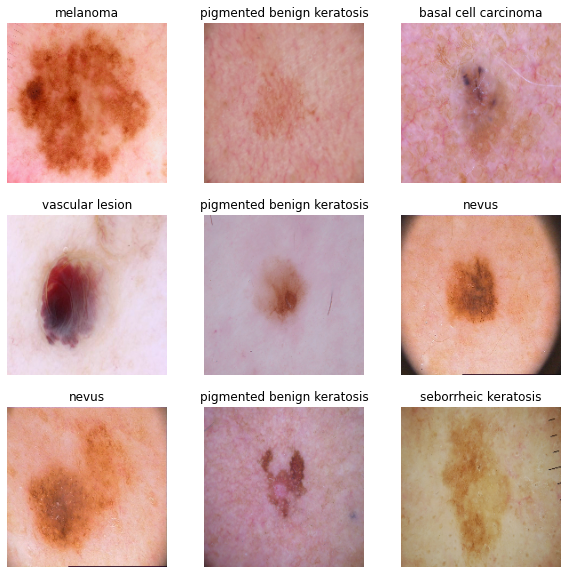

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & training
- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).

In [15]:
#Normalizing the data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [16]:
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0754902 0.9078432


In [17]:
num_class = len(class_names)
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

- Choose an appropriate optimiser and loss function for model training

In [18]:
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

- Viewing the summary of the trained model

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 2073600)           0         
                                                                 
 dense (Dense)               (None, 128)               265420928 
                                                                 
 dense_1 (Dense)             (None, 9)                 1

- Train the model for 20 epochs

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
55/55 [==============================] - 20s 183ms/step - loss: 9.2512 - accuracy: 0.2121 - val_loss: 2.2676 - val_accuracy: 0.1304
Epoch 2/20
55/55 [==============================] - 8s 138ms/step - loss: 1.9789 - accuracy: 0.2121 - val_loss: 2.2755 - val_accuracy: 0.1739
Epoch 3/20
55/55 [==============================] - 8s 140ms/step - loss: 1.9184 - accuracy: 0.2887 - val_loss: 2.8023 - val_accuracy: 0.1304
Epoch 4/20
55/55 [==============================] - 8s 140ms/step - loss: 1.7630 - accuracy: 0.4048 - val_loss: 2.2977 - val_accuracy: 0.1304
Epoch 5/20
55/55 [==============================] - 8s 140ms/step - loss: 1.4147 - accuracy: 0.5054 - val_loss: 2.5902 - val_accuracy: 0.1739
Epoch 6/20
55/55 [==============================] - 8s 141ms/step - loss: 1.1589 - accuracy: 0.6003 - val_loss: 2.6897 - val_accuracy: 0.0870
Epoch 7/20
55/55 [==============================] - 8s 141ms/step - loss: 0.8698 - accuracy: 0.6975 - val_loss: 3.3145 - val_accuracy: 0.1304
Epoch

### Here we can see the following metrics:
- Training Loss: 0.114
- Training Accuracy: 0.936
- Validation Loss: 7.218
- Validation Accuracy: 0.087

- Visualizing the training results

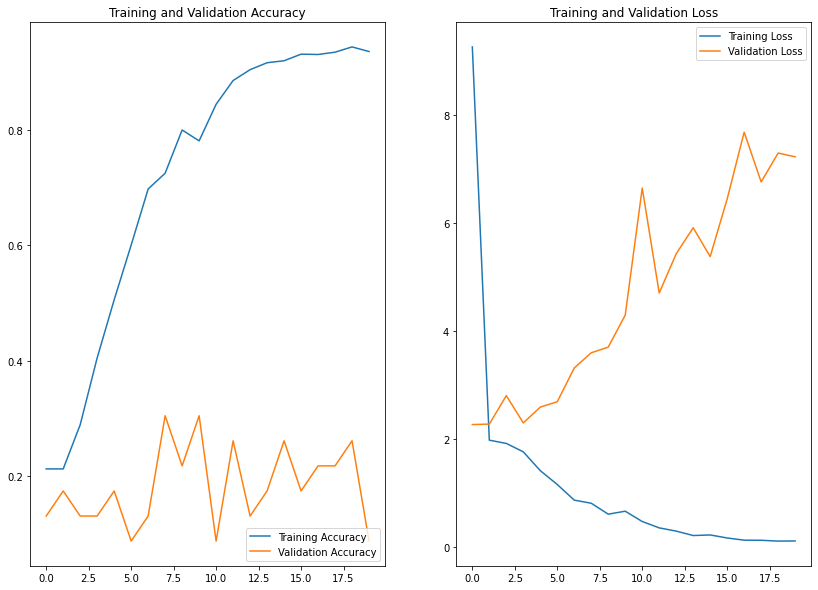

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

- Validation Accuracy is sliding downwards compared to Training Accuracy. This needs to be improved in next models.
- Training loss is less compared to validation loss.
- We can see here clearly that the model is overfitting, so to reduce this we are using augmentation.

In [22]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

- Checking how the augmentation strategy works for one instance of the training sample.

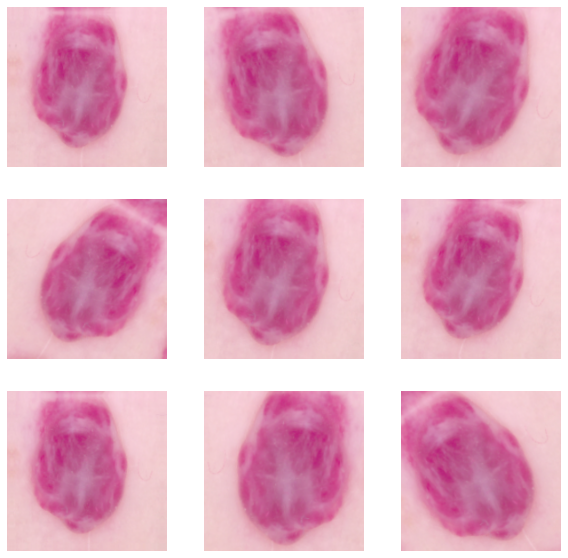

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

- we can add dropout layers if we find any case of overfitting in our trained models. As overfitting is seen in the trained model, we are adding dropout layers.

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class, name="outputs")
])

- Choose an appropriate optimiser and loss function for model training

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

- Checking model summary after adding augmentation.

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

- Train the model for 20 epochs after adding augmentation

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
55/55 [==============================] - 4s 45ms/step - loss: 1.9859 - accuracy: 0.2653 - val_loss: 2.3638 - val_accuracy: 0.1739
Epoch 2/20
55/55 [==============================] - 2s 40ms/step - loss: 1.7258 - accuracy: 0.3716 - val_loss: 2.4384 - val_accuracy: 0.2174
Epoch 3/20
55/55 [==============================] - 2s 38ms/step - loss: 1.6506 - accuracy: 0.4282 - val_loss: 2.4821 - val_accuracy: 0.1739
Epoch 4/20
55/55 [==============================] - 2s 38ms/step - loss: 1.6533 - accuracy: 0.4271 - val_loss: 2.4405 - val_accuracy: 0.2174
Epoch 5/20
55/55 [==============================] - 3s 58ms/step - loss: 1.4734 - accuracy: 0.4877 - val_loss: 2.3858 - val_accuracy: 0.3043
Epoch 6/20
55/55 [==============================] - 4s 65ms/step - loss: 1.3754 - accuracy: 0.5283 - val_loss: 2.3789 - val_accuracy: 0.3043
Epoch 7/20
55/55 [==============================] - 3s 56ms/step - loss: 1.3184 - accuracy: 0.5340 - val_loss: 2.0375 - val_accuracy: 0.3043
Epoch 8/20
55

### Here we can see the following metrics:
- Training Loss: 1.049
- Training Accuracy: 0.621
- Validation Loss: 2.536
- Validation Accuracy: 0.173

- Visualizing the model after augmentation

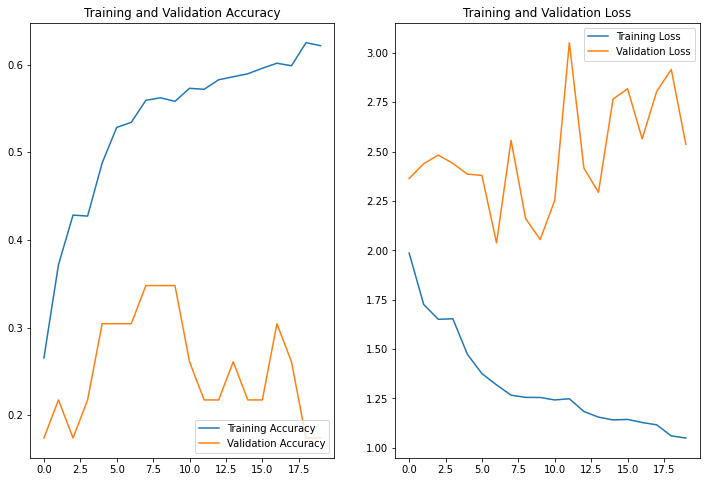

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Write your findings after the model fit, see if the earlier issue is resolved or not?

- The model needs to imporved further.
- As we can see still validation accuracy is getting low compared to Training Accuracy.
- This needs to be corrected in the following models.

### Class distribution: Examine the current class distribution in the training dataset 
- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?

<Figure size 720x720 with 0 Axes>

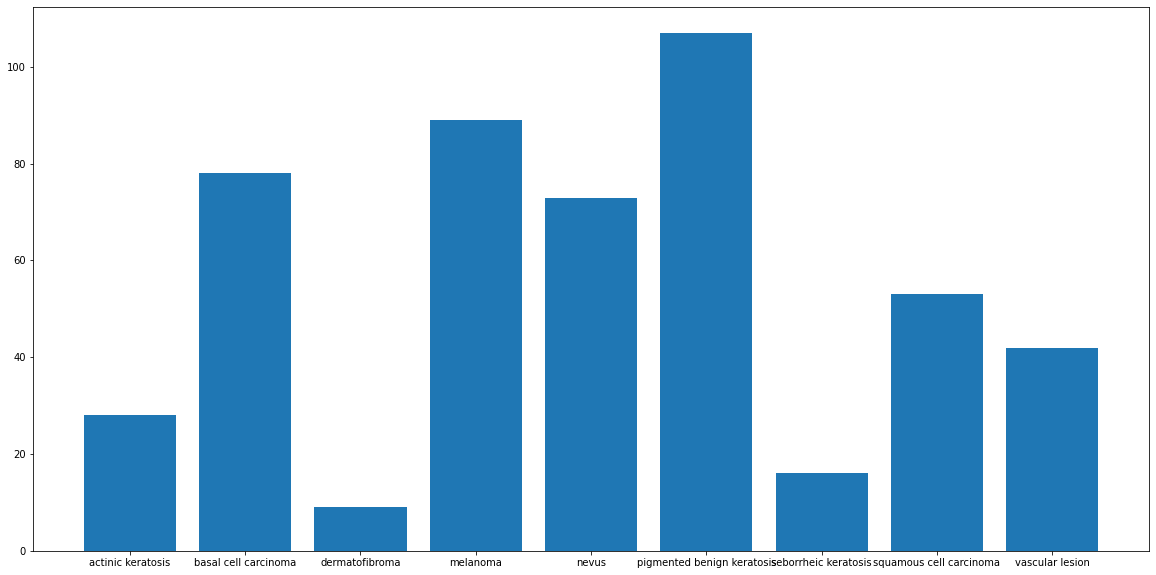

In [29]:
# Let's check on the Class Imbalance if Present
# taking empty dictionary
class_data = dict()

# adding the empty lists for each class record in the dictionary
for i in class_names:
  class_data[i] = []

# setting the output image size
plt.figure(figsize=(10, 10))
# adding the images into the data dictionary for each class
for images, labels in train_ds:
  for i in range(9):
    class_data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
# storing the number of images for specific class
for i in class_data:
  # getting the length and storing the dictionary
  class_data[i] = len(class_data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
# printing the plot
plt.bar(range(len(class_data)), list(class_data.values()), align='center')
plt.xticks(range(len(class_data)), list(class_data.keys()))
plt.show()

- Here we can see that pigmented benign has more samples and dermatofibroma has less samples among all classes.

## Handling class imbalances
- Rectify class imbalances present in the training dataset with Augmentor library.

In [30]:
# Installing Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# Importing the augmentor package 
import Augmentor

- For Training Datset doing this augmentation for handling imbalances.

In [32]:
training_path=("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

for i in class_names:
    p = Augmentor.Pipeline(training_path+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6145931750>: 100%|██████████| 500/500 [00:20<00:00, 24.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61B0052B90>: 100%|██████████| 500/500 [00:20<00:00, 24.24 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6145931790>: 100%|██████████| 500/500 [00:18<00:00, 26.57 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x545 at 0x7F6145815950>: 100%|██████████| 500/500 [01:29<00:00,  5.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F6144307550>: 100%|██████████| 500/500 [01:15<00:00,  6.64 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6145B9FBD0>: 100%|██████████| 500/500 [00:17<00:00, 27.83 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6145C09E90>: 100%|██████████| 500/500 [00:41<00:00, 12.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6145BFE350>: 100%|██████████| 500/500 [00:19<00:00, 26.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F615C0E6850>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


- After Augmentation. printing the image count in the training dataset.

In [33]:
image_count_train = len(list(train_data_dir.glob('*/output/*.jpg')))
print(f'Number of images in training dataset: {image_count_train}')

Number of images in training dataset: 4500


- Getting the length of the path list

In [34]:
path_list = [x for x in glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]
len(path_list)

4500

- The distribution of augmented data after adding new images to the original training data.

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

- printing the number of images under each type

In [37]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
nevus                         500
vascular lesion               500
Name: Label, dtype: int64

### Model Building & training on the rectified class imbalance data
- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [39]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=123,
    validation_split = 0.2,
    subset = 'validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [40]:
# performing autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#normalizing the Data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# creating a model post handling the imbalancing
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class)
])

0.07076261 0.8845735


- Choose an appropriate optimiser and loss function for model training for augmented data

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

- Train this model for 30 epochs

In [42]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 14s 77ms/step - loss: 2.2239 - accuracy: 0.1601 - val_loss: 2.2096 - val_accuracy: 0.2279
Epoch 2/30
169/169 [==============================] - 7s 42ms/step - loss: 1.6546 - accuracy: 0.3622 - val_loss: 1.5942 - val_accuracy: 0.3927
Epoch 3/30
169/169 [==============================] - 7s 41ms/step - loss: 1.4686 - accuracy: 0.4269 - val_loss: 1.3708 - val_accuracy: 0.4863
Epoch 4/30
169/169 [==============================] - 7s 41ms/step - loss: 1.4077 - accuracy: 0.4599 - val_loss: 1.3477 - val_accuracy: 0.4655
Epoch 5/30
169/169 [==============================] - 7s 41ms/step - loss: 1.3317 - accuracy: 0.4841 - val_loss: 1.2847 - val_accuracy: 0.5182
Epoch 6/30
169/169 [==============================] - 7s 41ms/step - loss: 1.2884 - accuracy: 0.5109 - val_loss: 1.2306 - val_accuracy: 0.5338
Epoch 7/30
169/169 [==============================] - 7s 41ms/step - loss: 1.2522 - accuracy: 0.5185 - val_loss: 1.1584 - val_accuracy: 0.557

### Here we can see the following metrics:
- Training Loss: 0.652
- Training Accuracy: 0.757
- Validation Loss: 0.720
- Validation Accuracy: 0.734

- Visualizing the trained model after adding augmented data

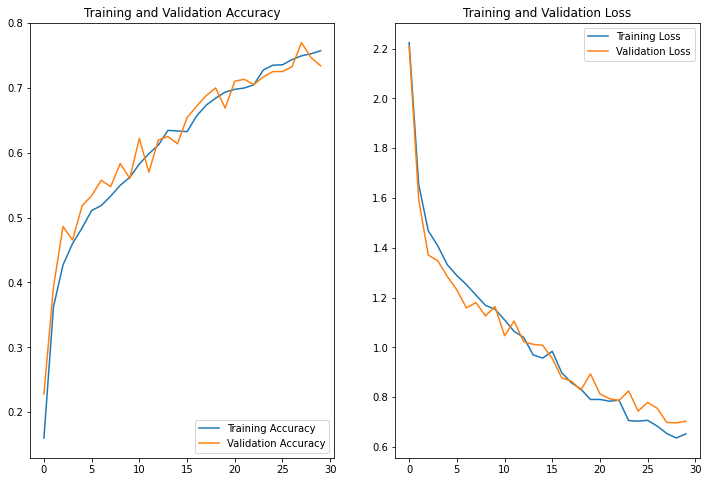

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings after the model fit, see if the issues are resolved or not?

- We can see now the training accuracy and validation accuracy matches with some little spikes up and down.
- The Validation loss is also less and is near to training accuracy.